# Radius of Gyration 
---

This notebook contains the procedure to calculate the radius of gyration for users. 

In [1]:
import pyspark as ps
from pyspark.sql.functions import *
sc = ps.SparkContext(appName="rg")

from pyspark.sql import * #This enables the SparkSession object
spark = SparkSession.builder\
        .master("local") \
        .appName("rg_df") \
        .getOrCreate()

In [2]:
import time 
import random 
import pandas as pd 
import numpy as np 
import seaborn as sns
import warnings
import geopandas as gpd
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import matplotlib.pyplot as plt

from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import pow, col, sqrt

from utils import date_format, save_table, drop_dates

## Data input 
- Transaction of frequent users 
- Home and work location of frequent users 
- Stations (to get the coordinates x, y of the stations)

In [3]:
output_path = '../data/output/'
input_path = '../data/input/'

transactions = spark.read.csv(output_path + 'tables/transactions_frequent_users.csv', header =True, sep = ',')
hw_location = spark.read.csv(output_path + 'tables/hw_location.csv', header =True, sep = ',')
probs = pd.read_csv(output_path + 'tables/stratum_probabilities.csv', parse_dates = ['date'],
                    infer_datetime_format= True).drop(columns = 'total')

In [4]:
stations = pd.read_csv(input_path + 'stations.csv').drop_duplicates(subset=['station_name'], keep = 'last')
stations = gpd.GeoDataFrame(stations, 
                            geometry = gpd.points_from_xy(stations.longitude, stations.latitude), 
                            crs = 'EPSG:4686')

#Project from degress to meters 
stations = stations.to_crs('EPSG:3116')
stations['x_m'] = stations.geometry.x
stations['y_m'] = stations.geometry.y
stations = spark.createDataFrame(stations)

## Radius of gyration

- **Number of transactions by user, date and station:** Summarie what stations each user has visited each day, and how many times as well. 

In [5]:
def daily_summary_user(df):
    return df.groupBy(['card_id', 'date', 'station_name']).agg({'valor':'count'})

def merge_home_locations(df, hw_locations):
    return df.join(hw_locations.select('card_id', 'home_station'), on = 'card_id', how = 'inner')

def merge_xy_coors(df, stations):
    result = df.join(stations.select('station_name', 'x_m', 'y_m'),
               on = 'station_name', how = 'inner')\
            .join(stations.selectExpr("station_name as home_station", "x_m as x_h", "y_m as y_h"), 
                 on = 'home_station', how = 'inner')
    return result

def filter_non_home_transactions(df):
    result = df.withColumn("not_home", col("station_name") != col("home_station"))
    result = result[result.not_home == 1]
    return result

def calculate_distance(df):
    """ Calculate distnace in meter between two station"""
    distance = sqrt(pow((df.x_m - df.x_h), 2) + pow((df.y_m - df.y_h), 2))/1000
    result = df.withColumn('distance_m', distance)
    return result

def calculate_total_distnace(df):
    """Distances traveled by that person: Distance multiply by the number of times station was 
       visited on that day. Most likely one station per day, but there are cases where a person 
       makes two transactions per day
    """
    dis_total = df['count(valor)'] * df.distance_m
    result = df.withColumn('dis_total_m', dis_total)
    return result

def group_distance_ind(df):
    """ Calculate total distance traveled and number of places visited (needed for Rg) for each person,
        each day. We also collect 'Localidad' and 'home station'. This will make future analysis easier
    """
    result = df.groupBy(['card_id', 'date']).agg({'count(valor)':'sum',
                                                  'dis_total_m':'sum',
                                                  'home_station':'First'})
    return result

def calculate_idv_rg(df):
    """ The rg is the division: Total Distance travel/transactions.
        
        Quick note here: For future reference 
        - sum(count(valor)): transactions by person by date. 
        - sum(dis_total_m): estimated of total distance traveled. 
    """
    rg = df['sum(dis_total_m)']/df['sum(count(valor))']
    result = df.withColumn('rg', rg)

    return result

def avg_rg_by_station(df):
    """ Calculate Average Rg and population by Home station by the day """
    
    group_by_cols = ['date', 'first(home_station)']
    result = df.groupBy(group_by_cols).agg(mean('rg'),stddev_pop("rg"), countDistinct('card_id')).cache()

    #Renaming variables 
    result = result.withColumnRenamed("first(home_station)", "station_name")\
                   .withColumnRenamed("avg(rg)","avg_rg")\
                   .withColumnRenamed("stddev_pop(rg)", "std_rg")\
                   .withColumnRenamed("count(card_id)","unique_users")
    
    return result    

In [6]:
rgs = transactions.withColumn('date', date_format())\
                  .transform(lambda df: daily_summary_user(df))\
                  .transform(lambda df: merge_home_locations(df, hw_location))\
                  .transform(lambda df: merge_xy_coors(df, stations))\
                  .transform(lambda df: filter_non_home_transactions(df))\
                  .transform(lambda df: calculate_distance(df))\
                  .transform(lambda df: calculate_total_distnace(df))\
                  .transform(lambda df: group_distance_ind(df))\
                  .transform(lambda df: calculate_idv_rg(df))\
                  .transform(lambda df: avg_rg_by_station(df))

In [7]:
df_rgs = rgs.toPandas()

In [8]:
df_rgs.head(5)

,date,station_name,avg_rg,std_rg,unique_users
0,2020-09-07,(05000) Portal Américas - alimentacion,10.802514,4.332372,11003
1,2020-03-07,(02000) Cabecera Autopista Norte - alimentacion,11.886808,6.264224,13721
2,2020-01-27,(09000) Cabecera Usme - alimentacion,13.293805,6.015261,23873
3,2020-03-04,(02300) Calle 100,9.285149,4.776932,7102
4,2020-10-06,(07000) Portal Sur - alimentacion,11.994007,4.913586,9297


### Rg by stratum
- This that are done in pandas 

In [9]:
def format_date(df, format_date = '%Y-%m-%d'):
    """ date colum formated as datetime object"""
    df['date'] = pd.to_datetime(df.date, format=format_date)
    return df

def merge_probs(df, probs):
    df = df.merge(probs, how = 'left', on = ['date', 'station_name']).dropna()
    return df 

In [10]:
def transaction_by_stratum(df, agg_col = 'transaction'):
    """
    Calculates transactions by stratum
    Min col requirements: 
    - Stratum probability columns 
    - agg_col: Transactions by station (or any other aggregated variable)
    
    output: 
    - Transaction (or other agg_col values) by stratum. Name will be "stratum1_t", and so on. 
    """
    
    stratum_vars = ['stratum1', 'stratum2', 'stratum3', 
                    'stratum4','stratum5', 'stratum6']#, 'total']
    
    stratum_transactions = ['stratum1_t', 'stratum2_t', 'stratum3_t', 
                            'stratum4_t','stratum5_t', 'stratum6_t']#, 'total_t']
    
    df[stratum_transactions] = (df[stratum_vars].mul(df[agg_col], axis = 0)).round(0)
    
    return df

In [11]:
def calculate_rg_stratum(df, agg_col = 'avg_rg'):
    """
    Calculates weighted average Rg by stratum
    Min col requirements: 
    - Transactions by stratum
    - Average Rg by station
    
    output: 
    - Average Rg by stratum  
    """
    stratum_transactions = ['stratum1_t', 'stratum2_t', 'stratum3_t', 
                            'stratum4_t','stratum5_t', 'stratum6_t']#, 'total_t']
    
    rg_stratum_transactions = ['stratum1_t_rg', 'stratum2_t_rg', 'stratum3_t_rg', 
                            'stratum4_t_rg','stratum5_t_rg', 'stratum6_t_rg']#, 'total_t_rg']
    a
    df[rg_stratum_transactions] = df[stratum_transactions].mul(df[agg_col], axis = 0)
    
    return df

In [12]:
def calculate_sums(df):
    ''' Calculate the sums by day 
    stratum1_t : Population * %Stratum
    stratum2_t_rg: Population * %stratum * av_rg_station
    '''
    res = df.groupby('date').agg({'stratum1_t':'sum', 'stratum2_t':'sum', 
                            'stratum3_t':'sum', 'stratum4_t':'sum', 
                            'stratum5_t':'sum', 'stratum6_t':'sum', 
                                  'stratum1_t_rg':'sum',
                            'stratum2_t_rg':'sum','stratum3_t_rg':'sum',
                            'stratum4_t_rg':'sum', 'stratum5_t_rg':'sum',
                            'stratum6_t_rg':'sum',}) #'total_t_rg':'sum', 'total_t':'sum'})
    
    return res

In [13]:
def calculate_rg(df):
    
    df['rg_stratum1']  = df['stratum1_t_rg']/df['stratum1_t']
    df['rg_stratum2']  = df['stratum2_t_rg']/df['stratum2_t']
    df['rg_stratum3']  = df['stratum3_t_rg']/df['stratum3_t']
    df['rg_stratum4']  = df['stratum4_t_rg']/df['stratum4_t']
    df['rg_stratum5']  = df['stratum5_t_rg']/df['stratum5_t']
    df['rg_stratum6']  = df['stratum6_t_rg']/df['stratum6_t']
#     df['rg_total']  = df['total_t_rg']/df['total_t']
    
    return df

In [14]:
def drop_dates(df):
    """
    Drops days: Data these days seems to be corrupted or non-existent
    """
    drop_dates = ['2020-03-09','2020-03-10','2020-03-12','2020-03-13',
                  '2020-06-02','2020-06-03','2020-06-06','2020-06-07',
                  '2020-04-10','2020-05-01','2020-05-25','2020-06-15',
                  '2020-06-22','2020-06-29','2020-07-20','2020-08-07',
                  '2020-08-17', '2020-04-27', '2020-10-12']
    
    res = df[~df.date.isin(drop_dates)]
    return res

In [15]:
def plot_formating(df):
    rgs = ['rg_stratum1', 'rg_stratum2', 'rg_stratum3',
           'rg_stratum4', 'rg_stratum5', 'rg_stratum6']
    
    def change_variable_name(df):
        df['variable'] = df['variable'].replace({'rg_stratum1':"Avg Rg - Stratum 1", 
                                                 'rg_stratum2':"Avg Rg - Stratum 2",
                                                 'rg_stratum3':"Avg Rg - Stratum 3", 
                                                 'rg_stratum4':"Avg Rg - Stratum 4", 
                                                 'rg_stratum5':"Avg Rg - Stratum 5", 
                                                 'rg_stratum6':"Avg Rg - Stratum 6",})
        return df
        
        
    res = df.melt(id_vars=['date'], value_vars = rgs)\
            .rename(columns = {'value':'Rg(km)'})\
            .pipe(change_variable_name)
    return res

In [16]:
def plot_formating_bogota(df):
    rgs = ['rg_total']
    
    def change_variable_name(df):
        df['variable'] = df['variable'].replace({'rg_total':"Avg Rg - Bogota"})
        return df
        
        
    res = df.melt(id_vars=['date'], value_vars = rgs)\
            .rename(columns = {'value':'Rg(km)'})\
            .pipe(change_variable_name)
    return res

In [17]:
def calculate_rg(df):
    """ Calculates the average Rg by stratum. This is a weighted average of the Average Rg of the station. 
        The wwight are the population by estrata in the give station
    """
    g = df.groupby('date')
    df_news = pd.concat([g.apply(lambda x: np.average(x.avg_rg, weights=x.stratum1_t)),
                         g.apply(lambda x: np.average(x.avg_rg, weights=x.stratum2_t)),
                         g.apply(lambda x: np.average(x.avg_rg, weights=x.stratum3_t)),
                         g.apply(lambda x: np.average(x.avg_rg, weights=x.stratum4_t)),
                         g.apply(lambda x: np.average(x.avg_rg, weights=x.stratum5_t)),
                         g.apply(lambda x: np.average(x.avg_rg, weights=x.stratum6_t)),], 
                         axis = 1, keys = ['rg_stratum1','rg_stratum2','rg_stratum3',
                                           'rg_stratum4','rg_stratum5','rg_stratum6'])
    
    return df_news.reset_index()

In [18]:
def weekday(df):
    day_of_week = df.date.dt.dayofweek
    df['weekday'] = day_of_week.isin([0,1,2,3,4]).astype(int)
    return df 

In [19]:
def before_covid(df):
    ''' Determines if day is before or after covid induce lockdowns'''
    df['covid'] = (df.date > '2020-03-23').astype(int)
    df['covid'] = df['covid'].replace({0:'before', 1:'after'})
    return df

In [20]:
rgs_strata = df_rgs.pipe(format_date,format_date = '%Y-%m-%d')\
                   .pipe(merge_probs, probs)\
                   .pipe(transaction_by_stratum, agg_col = 'unique_users')\
                   .pipe(calculate_rg)\
                   .pipe(weekday)\
                   .pipe(drop_dates).pipe(before_covid)


rgs_strata

,date,rg_stratum1,rg_stratum2,rg_stratum3,rg_stratum4,rg_stratum5,rg_stratum6,weekday,covid
0,2020-01-01,10.692209,10.635103,9.582696,10.319166,11.168567,10.797228,1,before
1,2020-01-02,11.563379,10.561486,9.022423,9.216700,10.002150,9.772327,1,before
2,2020-01-03,11.419667,10.455471,8.885057,9.083607,9.949335,9.686784,1,before
3,2020-01-04,11.208501,10.328242,8.796355,9.199105,10.316105,9.929044,0,before
4,2020-01-05,10.443437,10.128953,8.826329,9.404590,10.299057,9.961633,0,before
...,...,...,...,...,...,...,...,...,...
280,2020-10-07,11.211739,10.341153,8.855667,9.527446,10.724249,10.247540,1,after
281,2020-10-08,11.216805,10.345821,8.828699,9.513750,10.733044,10.351249,1,after
282,2020-10-09,11.205097,10.331408,8.806536,9.387270,10.641726,10.257017,1,after
283,2020-10-10,10.813525,10.050520,8.625972,9.452394,10.762290,10.312880,0,after


In [21]:
rgs = rgs_strata.melt(id_vars = ['date', 'weekday', 'covid'], 
                value_vars = ['rg_stratum1','rg_stratum2',
                              'rg_stratum3','rg_stratum4',
                              'rg_stratum5','rg_stratum6'])

In [22]:
rgs.head(2)

,date,weekday,covid,variable,value
0,2020-01-01,1,before,rg_stratum1,10.692209
1,2020-01-02,1,before,rg_stratum1,11.563379


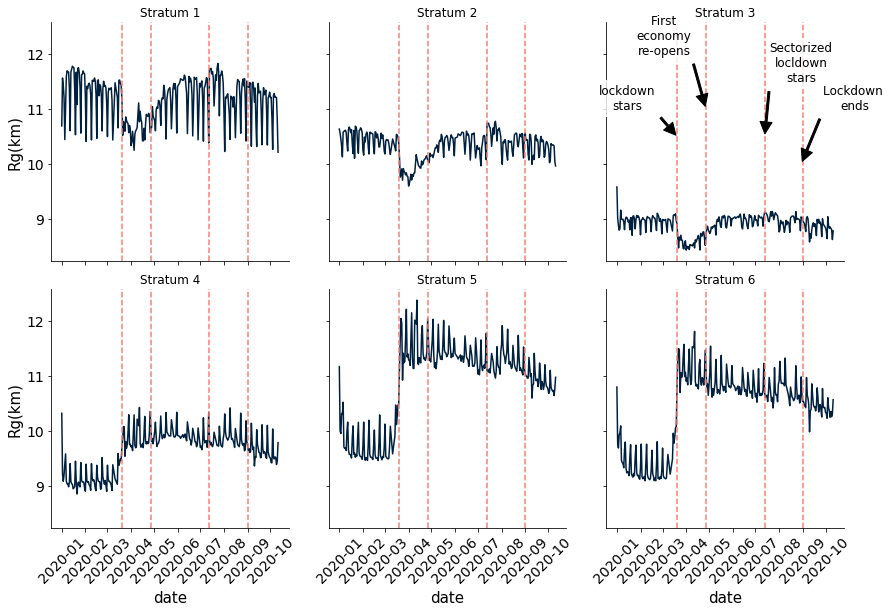

In [61]:
# apply_filter = rgs.weekday == 1
g = sns.FacetGrid(rgs, col="variable", col_wrap=3, height=4)
g = g.map(sns.lineplot, "date","value",color = '#00203FFF')
g.set_xticklabels(rotation = 45, fontsize = 14)

i = 1
for ax in g.axes.flat:
#     title = 'Stratum '+ str(i)
    ax.axvline(pd.date_range(start = '3/20/2020', end = '3/20/2020')[0], ls='--', color='salmon')
    ax.axvline(pd.date_range(start = '7/13/2020', end = '7/13/2020')[0], ls='--', color='salmon')
    ax.axvline(pd.date_range(start = '9/1/2020', end = '9/1/2020')[0], ls='--', color='salmon')
    ax.axvline(pd.date_range(start = '4/27/2020', end = '4/27/2020')[0], ls='--', color='salmon')
    ax.set_title(ax.get_title(), fontsize=15)
    ax.set_xlabel('date', fontsize=15)
    ax.set_ylabel('Rg(km)', fontsize=15)
    ax.set_title('Stratum '+ str(i))
    i = i + 1;
    
#Sectorize quarentine 
start = pd.date_range(start = '3/20/2020', end = '3/20/2020')
reopen = pd.date_range(start = '4/27/2020', end = '4/27/2020')
start_s = pd.date_range(start = '7/13/2020', end = '7/13/2020')
end = pd.date_range(start = '8/30/2020', end = '8/30/2020')

text = pd.date_range(start = '1/15/2020', end = '1/15/2020')
g.axes.flat[2].annotate('lockdown\nstars', xy = (start,10.5),xytext=(text,11),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':2},
            horizontalalignment='center',fontsize = 12)\
            .set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))


text = pd.date_range(start = '3/3/2020', end = '3/3/2020')
g.axes.flat[2].annotate('First\neconomy\nre-opens', xy = (reopen,11),xytext=(text,12),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':2},
            horizontalalignment='center',fontsize = 12)\
            .set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))


text = pd.date_range(start = '8/30/2020', end = '8/30/2020')
g.axes.flat[2].annotate('Sectorized\nlocldown\nstars', xy = (start_s,10.5),xytext=(text,11.5),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':2},
            horizontalalignment='center',fontsize = 12)\
            .set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

text = pd.date_range(start = '11/8/2020', end = '11/8/2020')
g.axes.flat[2].annotate('Lockdown \nends', xy = (date_5b,10),xytext=(text,11),
             arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':2},
            horizontalalignment='center',fontsize = 12)\
            .set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'));
g.savefig(output_path + 'figures/figure6.pdf')

In [24]:
## This plot only runs with Seaborn 0.11. 
colors = ['#00203FFF', '#006B38FF']
sns.set_palette(sns.color_palette(colors))

g = sns.displot(data=rgs, x="value", 
            hue='covid', col="variable",
            kind="kde", col_wrap = 3,height=5)
g.set_axis_labels("Rg(km)", "density", fontsize = 18)
# g.legend(fontsize = 20)

i = 1
for ax in g.axes.flat:
#     title = 'Stratum '+ str(i)
#     ax.axvline(pd.date_range(start = '3/20/2020', end = '3/20/2020')[0], color = 'gray')
#     ax.set_title(ax.get_title(), fontsize=15)
#     ax.set_xlabel('Rg(km)', fontsize=15)
#     ax.set_ylabel('count', fontsize=15)
    ax.set_title('')
    ax.text(11.5, 0.30, 'Stratum '+ str(i), fontsize = 15)
    i = i + 1;
g.savefig(output_path + 'figures/figure7.pdf')

AttributeError: module 'seaborn' has no attribute 'displot'

In [ ]:
a = rgs[~rgs.date.between("2020-03-24", "2020-04-27")]

In [ ]:
colors = ['#00203FFF', '#006B38FF']
sns.set_palette(sns.color_palette(colors))

g = sns.displot(data=a, x="value", 
            hue='covid', col="variable",
            kind="kde", col_wrap = 3,height=5)
g.set_axis_labels("Rg(km)", "density", fontsize = 18)
# g.legend(fontsize = 20)

i = 1
for ax in g.axes.flat:
#     title = 'Stratum '+ str(i)
#     ax.axvline(pd.date_range(start = '3/20/2020', end = '3/20/2020')[0], color = 'gray')
#     ax.set_title(ax.get_title(), fontsize=15)
#     ax.set_xlabel('Rg(km)', fontsize=15)
#     ax.set_ylabel('count', fontsize=15)
    ax.set_title('')
    ax.text(11.5, 0.40, 'Stratum '+ str(i), fontsize = 15)
    i = i + 1;

## Hypothesis testing mean difference 

In [27]:
from scipy import stats
filter_ = rgs_strata.covid == 'before'
value_vars = ['rg_stratum1','rg_stratum2',
              'rg_stratum3','rg_stratum4',
              'rg_stratum5','rg_stratum6']

for stratum in value_vars:
    a = stats.ttest_ind(rgs_strata[filter_][stratum],rgs_strata[~filter_][stratum],equal_var = False)
    print(a)


Ttest_indResult(statistic=3.2893248898720695, pvalue=0.001250971712717413)
Ttest_indResult(statistic=4.3245102574792655, pvalue=2.4979177871987693e-05)
Ttest_indResult(statistic=3.945187873729922, pvalue=0.00011377163685112791)
Ttest_indResult(statistic=-18.2404815051506, pvalue=8.837882792474017e-36)
Ttest_indResult(statistic=-21.1309692605476, pvalue=1.1085512109599886e-38)
Ttest_indResult(statistic=-19.971917133095204, pvalue=2.5969624577286152e-36)


In [28]:
for stratum in value_vars:
    before = rgs_strata[filter_][stratum]
    after = rgs_strata[~filter_][stratum]
    
    print("Stratum:", stratum)
    print ("Before>> \nmean:", before.mean(),
           'std:', before.std(), 
           'n:', len(before))
    print ("After>> \nmean:", after.mean(),
           'std:', after.std(), 
           'n:', len(after), "\n")
    
    
    

Stratum: rg_stratum1
Before>> 
mean: 11.290344756797374 std: 0.3970919298938283 n: 79
After>> 
mean: 11.113740570301061 std: 0.4082776372848465 n: 188 

Stratum: rg_stratum2
Before>> 
mean: 10.425141174497295 std: 0.2005772881926723 n: 79
After>> 
mean: 10.298615821050658 std: 0.25532447836652394 n: 188 

Stratum: rg_stratum3
Before>> 
mean: 8.959587752665925 std: 0.14201699960054112 n: 79
After>> 
mean: 8.878388554339313 std: 0.1778828923900284 n: 188 

Stratum: rg_stratum4
Before>> 
mean: 9.182656793687105 std: 0.2840221294778072 n: 79
After>> 
mean: 9.828897617384476 std: 0.20978224978600443 n: 188 

Stratum: rg_stratum5
Before>> 
mean: 9.868098545759025 std: 0.5508174584212296 n: 79
After>> 
mean: 11.264613874079632 std: 0.3148210462805007 n: 188 

Stratum: rg_stratum6
Before>> 
mean: 9.497766266698996 std: 0.5296665590998592 n: 79
After>> 
mean: 10.759693724174591 std: 0.28798074134561286 n: 188 



In [29]:
from statsmodels.stats.weightstats import ttest_ind
filter_ = rgs_strata.covid == 'before'
value_vars = ['rg_stratum1','rg_stratum2',
              'rg_stratum3','rg_stratum4',
              'rg_stratum5','rg_stratum6']

for stratum in value_vars:
    a = ttest_ind(rgs_strata[filter_][stratum],rgs_strata[~filter_][stratum], 
                  alternative = 'smaller',usevar = 'unequal' )

    print(a)
    
    

(3.2893248898719367, 0.999374514143641, 150.31765461894528)
(4.324510257479326, 0.999987510411064, 184.67233398045775)
(3.945187873729836, 0.9999431141815744, 181.78925217627523)
(-18.2404815051506, 4.418941396237009e-36, 115.33341849593776)
(-21.13096926054755, 5.542756054801129e-39, 100.09744589369662)
(-19.971917133095175, 1.2984812288644553e-36, 97.95143928075147)


## Hypothesis testing dropping from fisrt lockdown to april 27. 

In [34]:
second_hy = rgs_strata[~rgs_strata.date.between("2020-03-24", "2020-04-27")]

filter_ = second_hy.covid == 'before'
value_vars = ['rg_stratum1','rg_stratum2',
              'rg_stratum3','rg_stratum4',
              'rg_stratum5','rg_stratum6']

for stratum in value_vars:
    a = ttest_ind(second_hy[filter_][stratum],second_hy[~filter_][stratum], 
                  alternative = 'two-sided',usevar = 'unequal' )

    print(a)

(1.5251028621067246, 0.1293309240726237, 150.5868618782821)
(1.6065140447918704, 0.11030661085671259, 147.02479853904435)
(0.9748923644988079, 0.3313887032517575, 132.60714275245633)
(-17.732339281386576, 2.437893583668207e-35, 120.15079508358819)
(-20.43765380051365, 2.083318831331385e-37, 99.5860254147127)
(-19.066580575687397, 2.7328453566405378e-34, 95.29940041413035)


In [35]:
for stratum in value_vars:
    before = second_hy[filter_][stratum]
    after = second_hy[~filter_][stratum]
    
    print("Stratum:", stratum)
    print ("Before>> \nmean:", before.mean(),
           'std:', before.std(), 
           'n:', len(before))
    print ("After>> \nmean:", after.mean(),
           'std:', after.std(), 
           'n:', len(after), "\n")

Stratum: rg_stratum1
Before>> 
mean: 11.290344756797374 std: 0.3970919298938283 n: 79
After>> 
mean: 11.207933265701016 std: 0.37844168346223056 n: 155 

Stratum: rg_stratum2
Before>> 
mean: 10.425141174497295 std: 0.2005772881926723 n: 79
After>> 
mean: 10.381665107944592 std: 0.18596465951845073 n: 155 

Stratum: rg_stratum3
Before>> 
mean: 8.959587752665925 std: 0.14201699960054112 n: 79
After>> 
mean: 8.941543137216165 std: 0.11632103881237697 n: 155 

Stratum: rg_stratum4
Before>> 
mean: 9.182656793687105 std: 0.2840221294778072 n: 79
After>> 
mean: 9.819365254546533 std: 0.20387621792441724 n: 155 

Stratum: rg_stratum5
Before>> 
mean: 9.868098545759025 std: 0.5508174584212296 n: 79
After>> 
mean: 11.217530237315732 std: 0.28363536149181234 n: 155 

Stratum: rg_stratum6
Before>> 
mean: 9.497766266698996 std: 0.5296665590998592 n: 79
After>> 
mean: 10.694115230402412 std: 0.2445444080512338 n: 155 



In [127]:
# fig = plt.figure(constrained_layout=True, figsize = (16,8))


# spec = fig.add_gridspec(ncols=3, nrows=2 )

# before_1, after_1 = stratum_clasification(dfs_list, stratum = 1)
# ax1 = fig.add_subplot(spec[0, 0])
# sns.distplot(before_1.rg, ax = ax1, label = 'before', color = '#00203FFF')
# sns.distplot(after_1.rg, ax = ax1, label = 'after', color = '#006B38FF')
# ax1.legend(fontsize = 14)
# ax1.set_xlabel('Rg', fontsize = 18)
# ax1.set_ylabel('density', fontsize = 18)
# # ax1.set_yticks(np.linspace(0,8, 5)/100)
# ax1.text(-20,0.08,'Stratum 1', horizontalalignment='left');

# before_2, after_2 = stratum_clasification(dfs_list, stratum = 2)
# ax2 = fig.add_subplot(spec[0, 1], sharey=ax1, sharex = ax1)
# sns.distplot(before_2.rg, ax = ax2, label = 'before', color = '#00203FFF')
# sns.distplot(after_2.rg, ax = ax2, label = 'after', color = '#006B38FF')
# ax2.legend(fontsize = 14)
# ax2.set_xlabel('Rg', fontsize = 18)
# ax2.set_ylabel('density', fontsize = 18)
# # ax2.set_yticks(np.linspace(0,8, 5)/100)
# ax2.text(-20,0.08,'Stratum 2', horizontalalignment='left');

# before_3, after_3 = stratum_clasification(dfs_list, stratum = 3)
# ax3 = fig.add_subplot(spec[0, 2], sharey=ax1, sharex = ax1)
# sns.distplot(before_3.rg, ax = ax3, label = 'before', color = '#00203FFF')
# sns.distplot(after_3.rg, ax = ax3, label = 'after', color = '#006B38FF')
# ax3.legend(fontsize = 14)
# ax3.set_xlabel('Rg', fontsize = 18)
# ax3.set_ylabel('density', fontsize = 18)
# # ax3.set_yticks(np.linspace(0,8, 5)/100)
# ax3.text(-20,0.08,'Stratum 3', horizontalalignment='left');

# before_4, after_4 = stratum_clasification(dfs_list, stratum = 4)
# ax4 = fig.add_subplot(spec[1, 0], sharey=ax1, sharex = ax1)
# sns.distplot(before_4.rg, ax = ax4, label = 'before', color = '#00203FFF')
# sns.distplot(after_4.rg, ax = ax4, label = 'after', color = '#006B38FF')
# ax4.legend(fontsize = 14)
# ax4.set_xlabel('Rg', fontsize = 18)
# ax4.set_ylabel('density', fontsize = 18)
# # ax4.set_yticks(np.linspace(0,8, 5)/100)
# ax4.text(-20,0.08,'Stratum 4', horizontalalignment='left');

# before_5, after_5 = stratum_clasification(dfs_list, stratum = 5)
# ax5 = fig.add_subplot(spec[1, 1], sharey=ax1, sharex = ax1)
# sns.distplot(before_5.rg, ax = ax5, label = 'before', color = '#00203FFF')
# sns.distplot(after_5.rg, ax = ax5, label = 'after', color = '#006B38FF')
# ax5.legend(fontsize = 14)
# ax5.set_xlabel('Rg', fontsize = 18)
# ax5.set_ylabel('density', fontsize = 18)
# # ax5.set_yticks(np.linspace(0,8, 5)/100)
# ax5.text(-20,0.08,'Stratum 5', horizontalalignment='left');

# before_6, after_6 = stratum_clasification(dfs_list, stratum = 6)
# ax6 = fig.add_subplot(spec[1, 2], sharey=ax1, sharex = ax1)
# sns.distplot(before_6.rg, ax = ax6, label = 'before', color = '#00203FFF')
# sns.distplot(after_6.rg, ax = ax6, label = 'after', color = '#006B38FF')
# ax6.legend(fontsize = 14)
# ax6.set_xlabel('Rg', fontsize = 18)
# ax6.set_ylabel('density', fontsize = 18)
# # ax6.set_yticks(np.linspace(0,8, 5)/100)
# ax6.text(-20,0.08,'Stratum 6', horizontalalignment='left');